In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## <span style="color:black">**Regression Modelling of Life Expectancy - Noah Rubin**</span>

---

<ins>Project Overview:</ins>

In this personal project I look into ways of modelling life expectancy using a variety of regression techniques, including:
* Ordinary Least Squares Regression
* Ridge Regression
* LASSO Regression
* Elastic Net Regression
* Decision Tree Regression
* Random Forest Regression
* Gradient Boosting
* Adaptive Boosting
* Catboost Regression
* Extreme Gradient Boosting (XGBoost)

---

The variables in my original dataset include:
* **Country**
* **Year**
* **InfantMortality:** The number of infants dying before the age of one, per 1000 live births
* **Health_exp:** The percentage of their total GDP that a country has spent on health
* **Life_exp:** Life expectancy at birth (this was the dependent variable for all the models I built)
* **GDP_cap:** Per capita income in $USD
* **Employment:** Employment to population ratio for people over the age of 15.
* **Status:** Whether they are a developed or a developing country
* **MeanSchooling:** Average number of completed years of education for those aged 25 years and older
* **ElectricityAccess:** The percentage of the population who have access to electricity

---

This first notebook will predominantly consist of basic cleaning and some visualisations.

In [2]:
# .py files attached
import data_cleaning as dc
import basic_visuals as bv
import interactive_plots as iplots

import numpy as np
import pandas as pd
import pandas_bokeh as pdbk
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.models import Legend

from scipy import stats
from sklearn.model_selection import train_test_split

# Display settings and allowing this notebook to update with any changes made to .py files
plt.style.use('seaborn-whitegrid') 
%config InlineBackend.figure_format = 'svg'  
%load_ext autoreload
%autoreload 2
pdbk.output_notebook()

Loading BokehJS ...

In [3]:
# Load in the data
possible_nans = ['na', 'Na', 'NA', 'null', 'Null', 'NULL', 'missing', 
                 'Nan', 'NAN', 'Nan', 'NAN', 'Absent', '?', '.', '..', 
                 'Missing', 'MISSING', 'Missing Value', '-999999', '']

df = pd.read_csv('../data/OriginalDataset.csv', na_values=possible_nans)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2793 entries, 0 to 2792
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            2793 non-null   object 
 1   Year               2793 non-null   int64  
 2   InfantMortality    2793 non-null   float64
 3   Health_exp         2754 non-null   float64
 4   Life_exp           2793 non-null   float64
 5   GDP_cap            2769 non-null   float64
 6   Employment         2736 non-null   float64
 7   Status             2793 non-null   object 
 8   MeanSchooling      2746 non-null   float64
 9   ElectricityAccess  2705 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 218.3+ KB
None


Country  Year  InfantMortality  Health_exp  Life_exp  \
0           Afghanistan  2000             90.2         NaN    55.841   
1                Angola  2000            121.2    1.908599    46.522   
2               Albania  2000             24.1    7.233370    73.955   
3  United Arab Emirates  2000              9.6    2.374135    74.327   
4             Argentina  2000             17.5    8.466964    73.576   

        GDP_cap  Employment      Status  MeanSchooling  ElectricityAccess  
0           NaN   42.189999  Developing            2.2                NaN  
1    556.836318   74.540001  Developing            4.4                NaN  
2   1126.683318   52.090000  Developing            8.8         100.000000  
3  33291.419366   74.250000   Developed            8.3         100.000000  
4   7708.100996   52.580002  Developing            9.1          95.445366

In [4]:
# Display missing data
dc.display_missing_data(df, (10, 6));

#### <span style="color:black">**<u>Initial Data Cleaning**</u></span>
* Lowers the chances of drawing the wrong conclusions from the data
* Distance based algorithms in general are sensitive to outliers

#### <span style="color:black"><u>**Cleaning**</u></span>

a) Handling <u>inconsistent data</u>: Removing whitespace, fixing case issues, handling blank strings. It ensures that 'Australia' and '  austrAlia   ' are treated the same

b) Handling <u>unessessary</u> data: Duplicated rows, or duplicates of subsets of particular rows

---

Then:

* Some basic (non-statistical) data analysis 

* More statistics heavy Exploratory Data Analysis **(next notebook)**



#### <span style="color:black">**a) Removing whitespace, fixing case issues, handling blank strings**</span>

In [5]:
# Uncomment the line below and comment the one below that
# ?dc.process_inconsistent_data
df = dc.process_inconsistent_data(df)

In [6]:
# Check country names to see that there is no 'Aus' or 'Aust' instead of 'Australia' etc. 
df.Country.unique()

array(['Afghanistan', 'Angola', 'Albania', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Belarus', 'Belize', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Central African Republic',
       'Canada', 'Switzerland', 'Chile', 'China', 'Cameroon', 'Colombia',
       'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba', 'Cyprus', 'Germany',
       'Djibouti', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador',
       'Eritrea', 'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji',
       'France', 'Gabon', 'United Kingdom', 'Georgia', 'Ghana', 'Guinea',
       'Guinea-Bissau', 'Equatorial Guinea', 'Greece', 'Grenada',
       'Guatemala', 'Guyana', 'Honduras', 'Croatia', 'Haiti', 'Hungary',
       'Indonesia', 'India', 'Ireland', 'Iraq', 'Iceland', 'Israel',
       'Italy', 'Jamaica', 'Jordan', 'Japan', 'Kazakhstan', 'Kenya',
       'Cambod

#### <span style="color:black">**b) Check for duplicated rows, or duplicates of subsets of particular rows**</span>

In [7]:
# There are no complete copies of particular rows
print(df.duplicated().sum() == 0)

# What if a subset is duplicated (e.g. repeated (Country, Year) combination)
print(df.duplicated(subset=['Country', 'Year']).sum() == 0)  # No duplicated data

True
True


## <span style="color:black">**<u>Exploratory Data Analysis</u>**</span>

- [Exploratory Data Analysis](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15) (EDA) through statistical techniques and visualisation methods can help summarise relationships and patterns in our dataset. 
- We can perform univariate analysis, bivariate analysis and multivariate analysis, all of which can help us in areas such as outlier detection and feature selection
- This notebook will have some surface level EDA

---

a) Basic data analysis.

b) Outlier detection on a univariate, bivariate and multivariate level. **This stats focused part will be in the next notebook**

---

#### <span style="color:black">**a) Basic Data Analysis**</span>
- Through plots

#### <span style="color:black"><u>Categorical Variables: Country & Status</u></span>

In [8]:
# All countries appear 19 times (2000-2018)
df.Country.value_counts()

Afghanistan         19
Papua New Guinea    19
Mauritania          19
Mauritius           19
Malawi              19
                    ..
Georgia             19
Ghana               19
Guinea              19
Guinea-Bissau       19
Zambia              19
Name: Country, Length: 147, dtype: int64

#### Status

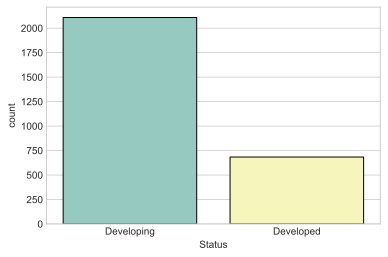

In [9]:
# Count plot of developing and developed countries
sns.countplot(x='Status', data=df, palette='Set3', edgecolor='black');

#### <span style="color:black"><u>Numeric Variables</u></span>

In [10]:
# Useful for looping through columns
numeric_variables = df.select_dtypes(include=np.number).columns[1:]  # [1:] since I'm not including year

<span style="color:red">Comparing the developing world against the developed world</span>

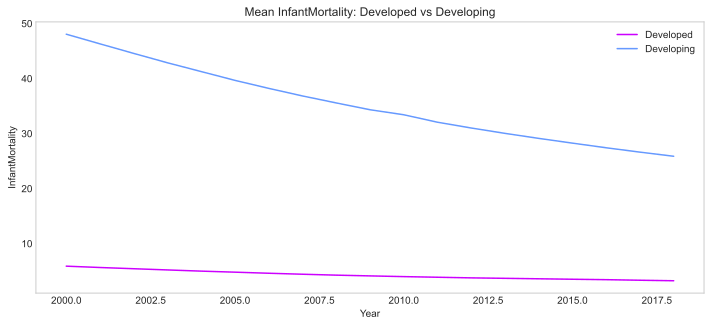

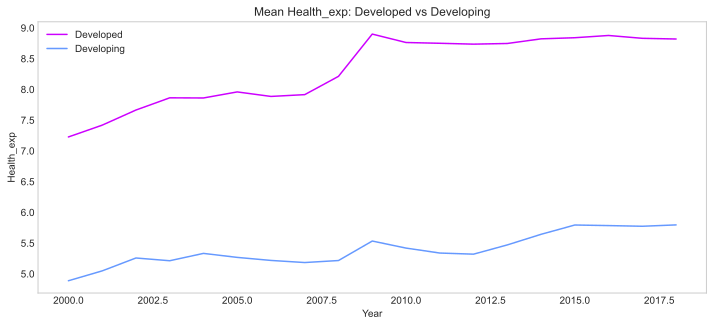

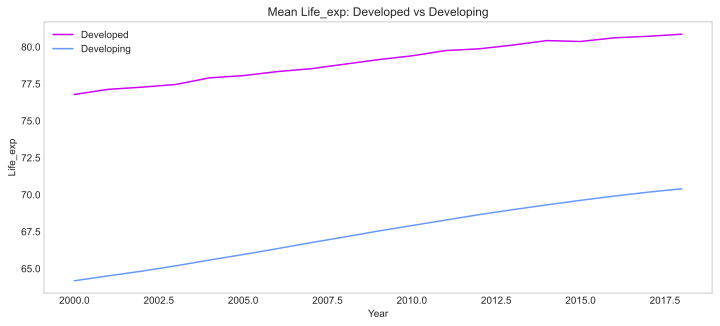

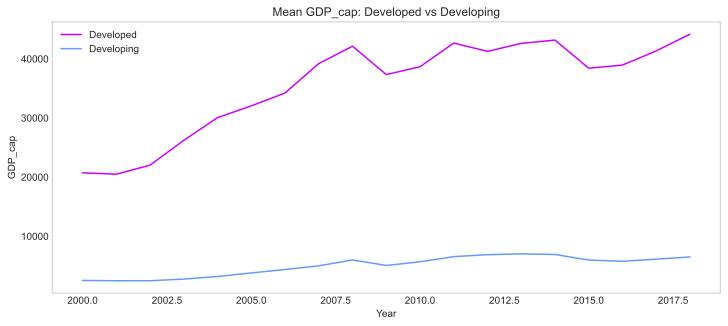

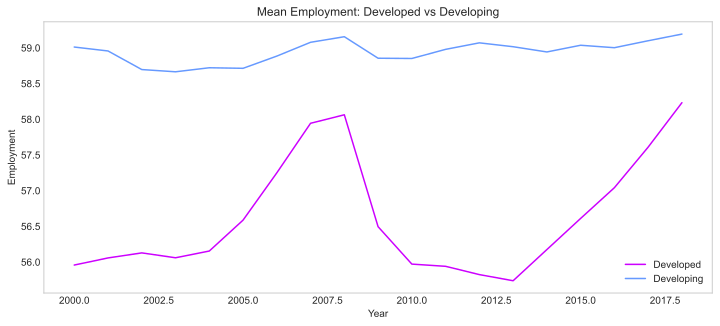

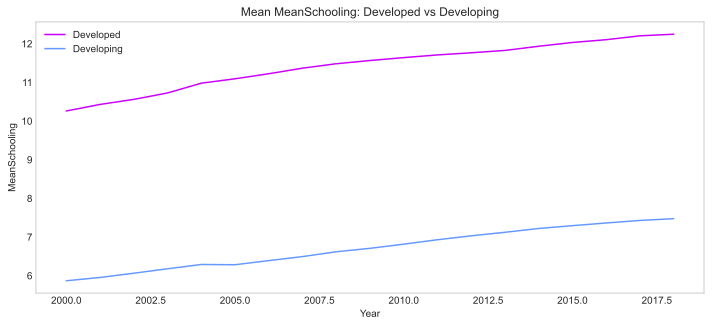

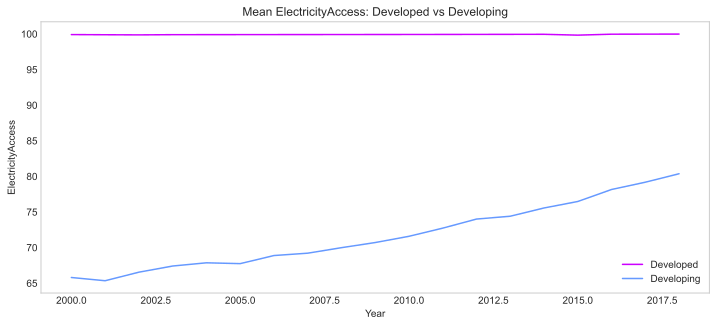

In [11]:
bv.compare_status(data=df)

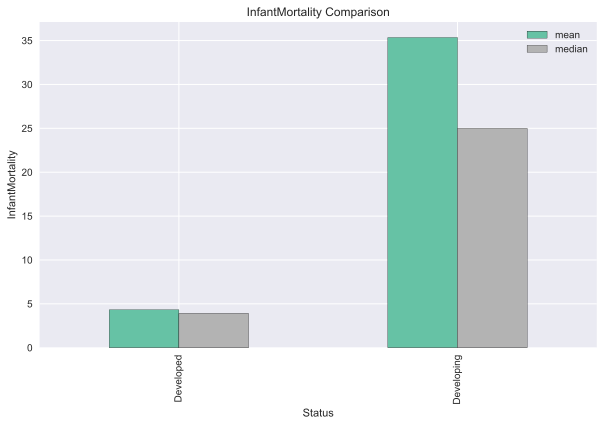

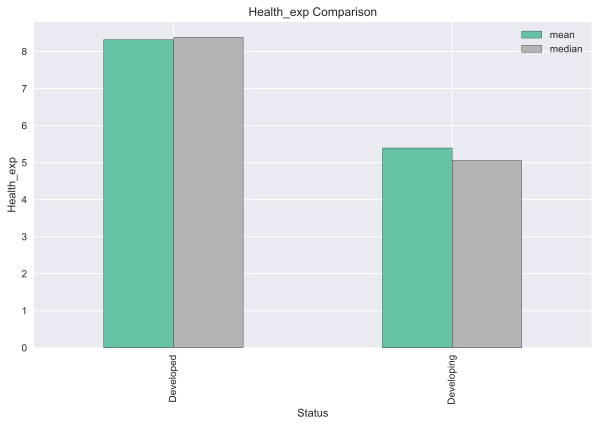

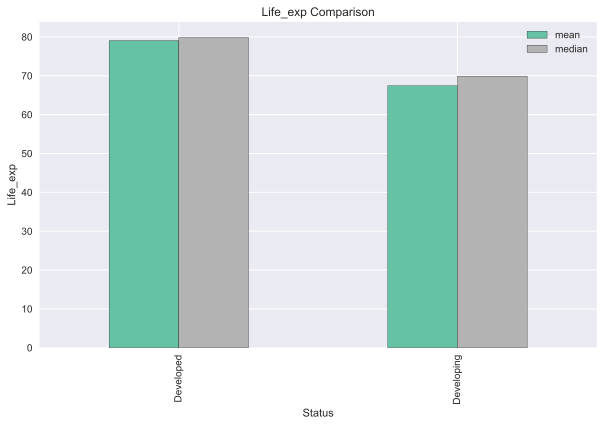

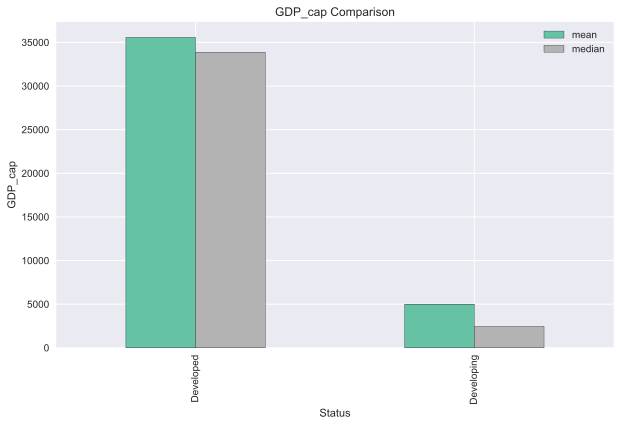

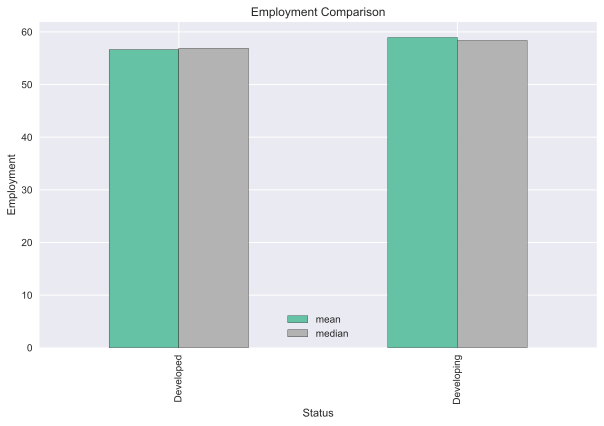

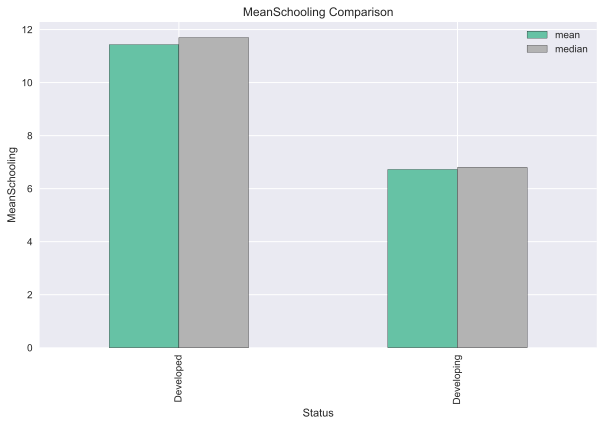

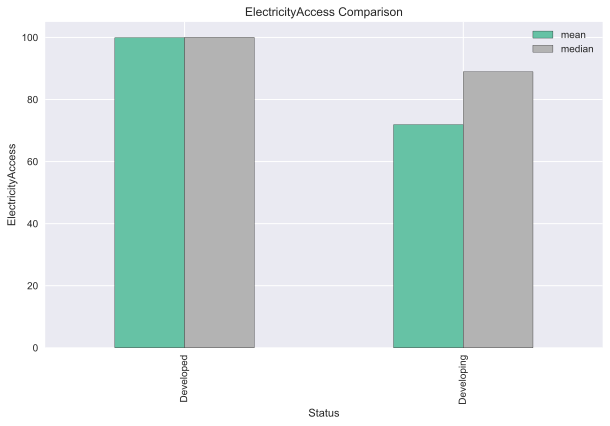

In [12]:
for var in numeric_variables:
    bv.mean_median_comparison(df, aggregation_variable=var)

<span style="color:red">Comparing the top and bottom five countries through various measures (see below)</span>

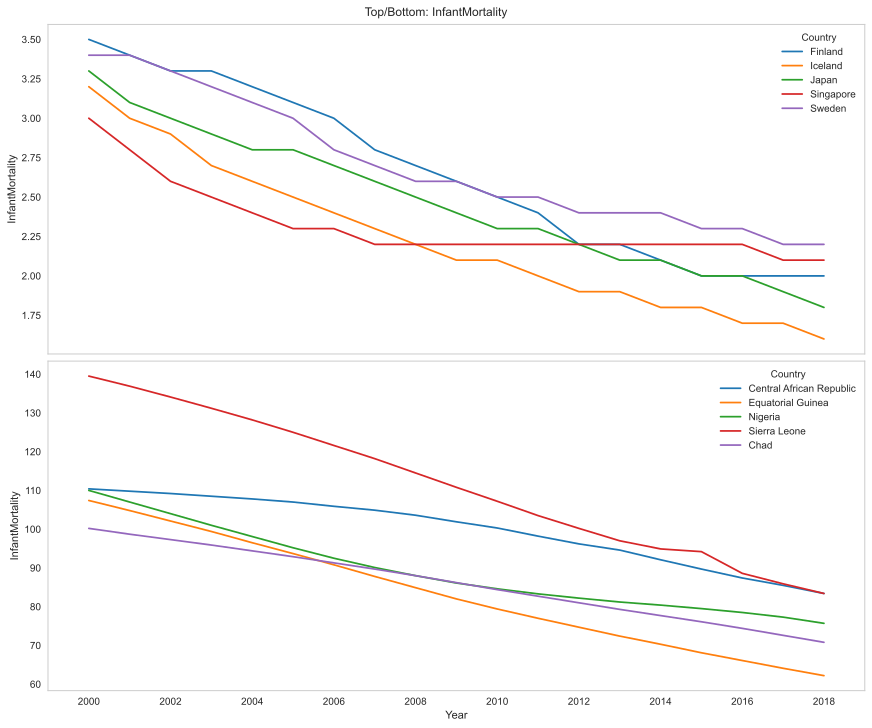

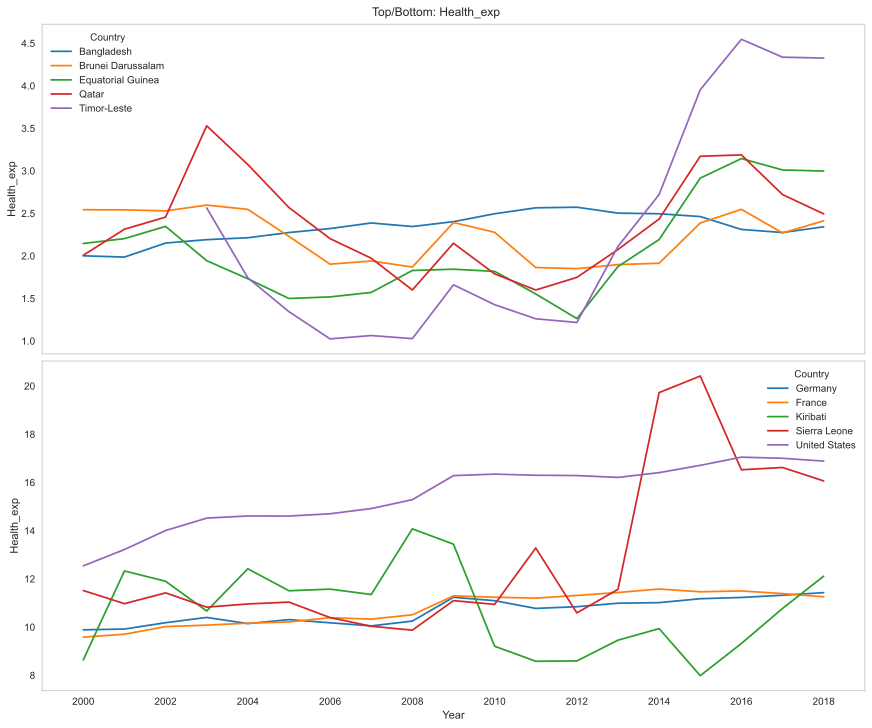

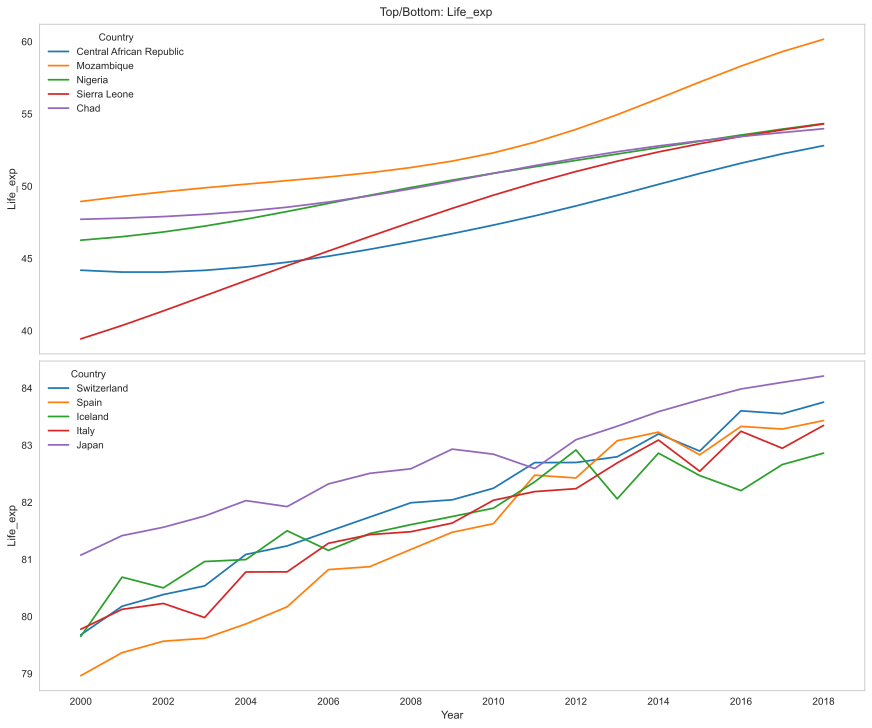

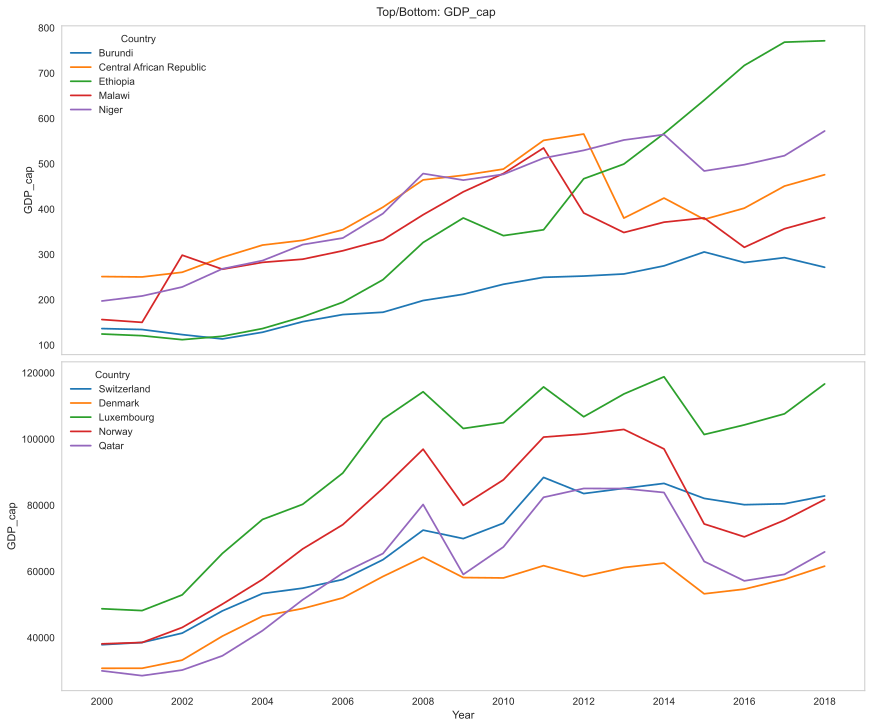

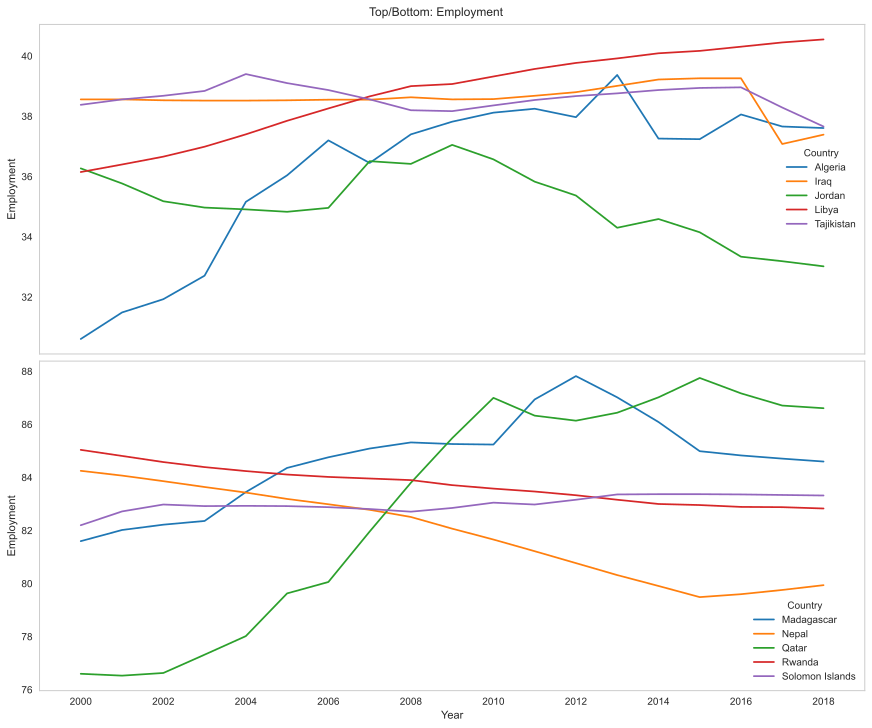

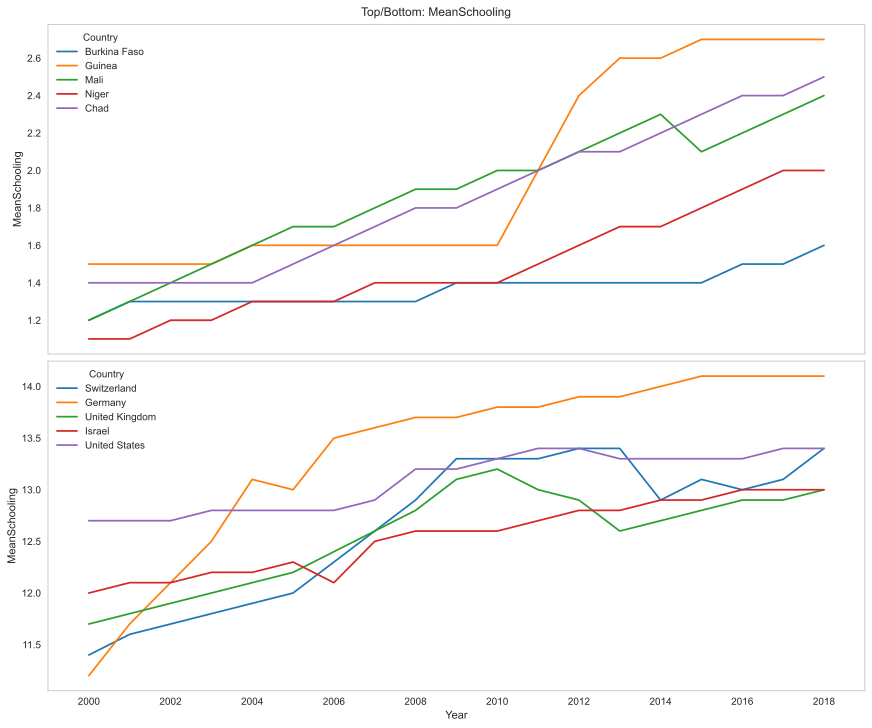

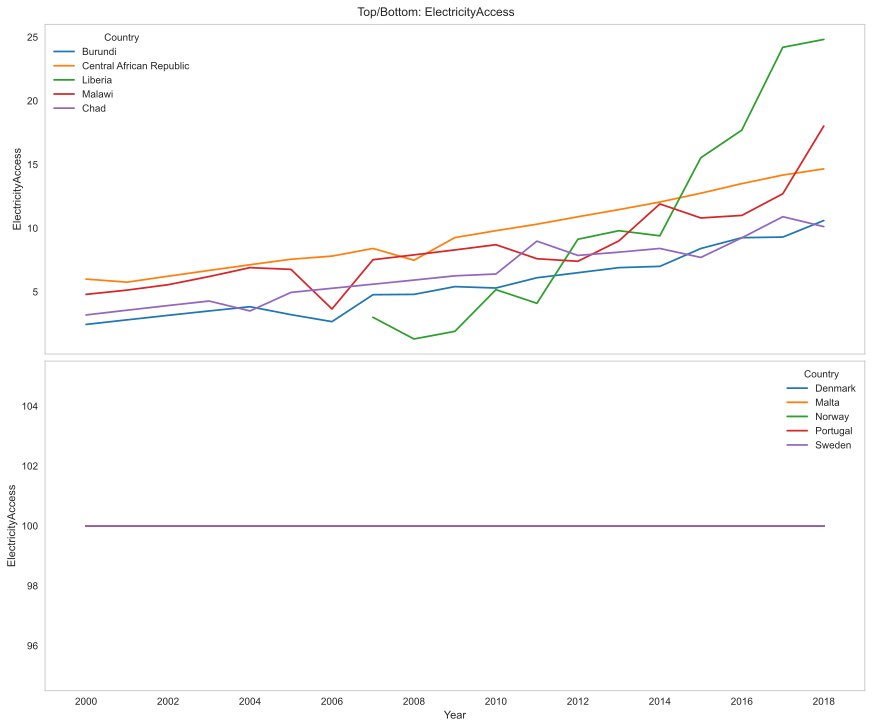

In [13]:
for var in numeric_variables:
    bv.top_five_bottom_five(data=df, aggregation_variable=var)

<span style="color:red">Highest relative change in GDP per capita</span>

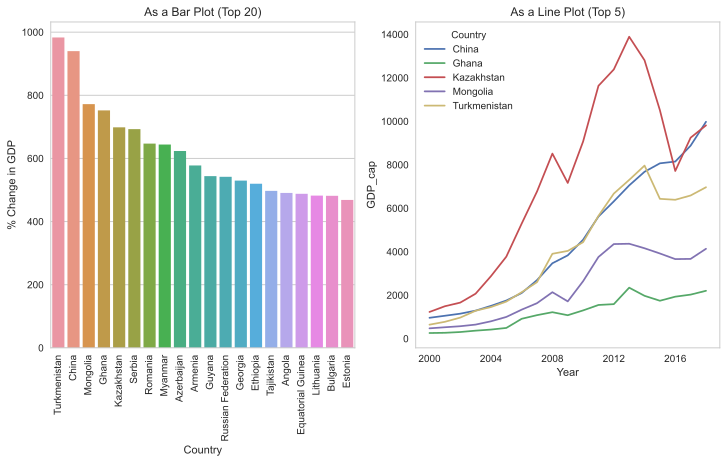

In [14]:
bv.plot_gdp_growth(df, top_n_bar=20, top_n_line=5)

<span style="color:red">Comparing different countries</span>

Countries to choose from:

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kuwait', 'Latvia', 'Lebanon', 'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', '

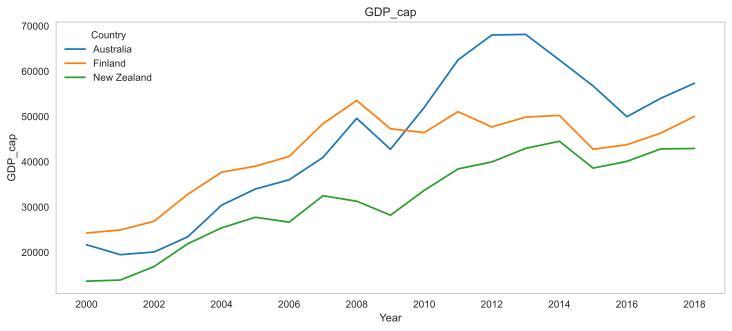

In [17]:
iplots.country_comparisons(df)

<span style="color:red">Lowest life expectancy recorded in this dataset</span>

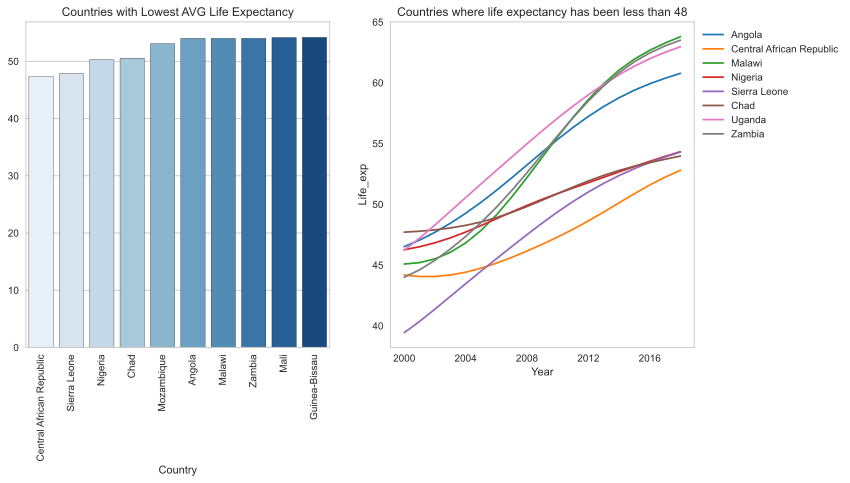

In [24]:
bv.low_life_exp(df, value=48, figsize=(12, 6))

In [ ]:
for var in numeric_variables:
    print(var)

### Life Expectancy Variable
--- 

#### Q: Which countries have the lowest life expectancy?
Lets see which nations are falling behind in this respect

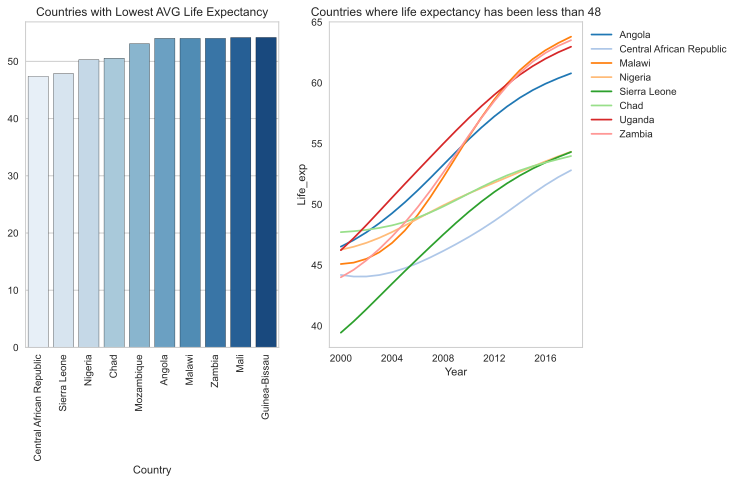

In [18]:
bv.low_life_exp(df, value=48, fig_s=(10, 6))

In [ ]:
# Compare mean and median life expectancy 
bv.mean_median_comparison(df, 'Life_exp')

In [ ]:
df.loc[df.Country == 'Poland', 'Status'] = 'Developed'

#### Task: Create a summary of the top and bottom five life countries for life expectancy

In [ ]:
# Use our function
bv.top_five_bottom_five(data=df, aggregation_variable = 'Life_exp')

## Infant Mortality Feature

--- 

#### Q: How does infant mortality in Australia (per 1000) compare to some other countries

In [ ]:
# Graph some mortality rates
interesting_countries = ['Australia', 'United States', 'United Kingdom',
                         'Germany', 'Finland', 'Japan', 'France',
                         'New Zealand', 'Sweden', 'Canada']

devpt_countries = df[df.Country.isin(interesting_countries)]

# Plot these countries on a line plot
fig, ax1 = plt.subplots(figsize = (10, 6))

sns.lineplot(x = 'Year', 
             y = 'InfantMortality', 
             hue = 'Country',
             palette = 'tab20',
             data = devpt_countries,
             ax = ax1)

# Adjust title, x markers and legend
ax1.set(title = 'Infant Mortality', xticks = np.arange(2000, 2020, 2))
ax1.legend(labelcolor = 'black', loc = 'best', bbox_to_anchor = [1, 1])
plt.grid(False);

#### Q: Which countries are struggling the most with high infant mortality and which countries have the lowest rates. What is the genral trend for these countries?

In [ ]:
# Reuse best/worst function from before
graph_best_worst_countries(aggregation_variable = 'InfantMortality')

In [ ]:
# The rates are lowering but the developing world is lagging far behind
df.groupby(['Year', 'Status'])['InfantMortality'].mean().plot(kind='bar', 
                                                              color='grey',
                                                              ylabel='Infant Mortality/1000',
                                                              figsize=(10, 10));

## Schooling Feature

#### Question: Which countries have had average 'MeanSchooling' less than 6 years on average (about the equivalent of finishing primary school)

In [ ]:
# Could do color=sns.color_palette("winter") but don't worry about it
plt.style.use('dark_background')

country_grouping_schooling = df[df.MeanSchooling <= 6].groupby('Country')['MeanSchooling'].mean()

country_grouping_schooling.sort_values().plot(kind = 'barh',
                                              figsize = (10, 10),
                                              xlabel = 'Mean Schooling',
                                              color = '#9933ff',
                                              grid = False,
                                              title = 'Average Years of Schooling by Country (Under 6 Years Only)',
                                              xlim = (0, 6.5));

## GDP Per Capita Feature
---
#### Q: Which countries are struggling the most economically? Which countries are the most well off?

In [ ]:
# Reuse my function
graph_best_worst_countries(aggregation_variable = 'GDP_cap', style = 'dark_background')

#### Q: Which countries have experienced the highest percentage growth in per capita income  since 2000?

In [ ]:
pct_growth = bv.obtain_largest_pct_growth(df)
pct_growth

In [ ]:
bv.plot_gdp_growth(df, 20, 5)

## Health Expenditure Feature
---
#### Q: How have attitudes towards health changed over the years

In [ ]:
# We see that the world has started to prioritise health expenditure
# Perhaps governments believe that allocating more to health will ultimately improve the overall GDP
# ...due to increased workforce productivity from a healthier overall population living longer
# Beliow is how % of gdp spent on health has changed over time

df.groupby('Year')['Health_exp'].mean().plot_bokeh(kind='line',
                                                   title='Health Expentiture Trend: (All Countries)',
                                                   color='red',
                                                   panning=False,
                                                   rangetool=True,
                                                   zooming=False,
                                                   ylabel='% of Total Expenditure');

legend = Legend(location=(30, 100))

In [ ]:
# Reuse function again to see relative smallest/biggest spenders on health expentiture
graph_best_worst_countries('Health_exp')

> Summary...

In [ ]:
df.select_dtypes(include = np.number).columns[:]

In [ ]:
bv.compare_status()

In [ ]:
# Create separate datasets for developed and developing counbtries
developed = df[df.Status == 'Developed'].copy()
developing = df[df.Status == 'Developing'].copy()

# Loop through all the numeric varibles, plotting on the y with year as the x variable
for column in df.select_dtypes(include = np.number).columns[1:]:
    fig, ax = plt.subplots()

    # Developed Countries
    developed.groupby('Year')[column].mean().plot(kind='line',
                                                  color='#cc00ff',
                                                  label='Developed',
                                                  ax=ax)
    # Developing Countries
    developing.groupby('Year')[column].mean().plot(kind='line',
                                                   color='#6699ff',
                                                   label='Developing',
                                                   ax=ax)
    
    plt.title(f"Mean {column}: Developed vs Developing")
    plt.ylabel(column)
    plt.grid(False)
    plt.legend();

# Split Data into Train/Test & Save to CSV

Save the training and test dataset in separate csv files. Putting the testing set away for a bit until I evaluate my final model on it to see how well a model performs on unseen data.

In [ ]:
train, test = train_test_split(df, train_size = 0.75, random_state = 10)

In [ ]:
train.to_csv('../data/training.csv', index = False)
test.to_csv('../data/testing.csv', index = False)